In [1]:
import os, sys

sys.path.append(os.path.dirname(os.getcwd())) 

In [2]:
from scipy.integrate import trapezoid
import scipy.optimize as optim

from scipy.constants import epsilon_0, elementary_charge, Boltzmann, Avogadro
import numpy as np
import matplotlib.pyplot as plt
import siunits as unit

from src.helper_functions import read_render_markdown_file

In [3]:
def make_simple_plot(x, y, xlabel, ylabel, title):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    plt.xlim([0, 10])
    plt.ylim([-20, 40])
    ax.grid()
    plt.show()

### Physical constants

1. the electric constant (vacuum permittivity) $\epsilon_0$. Units:  $\textstyle{\rm s^{4}\cdot A^{2}\cdot kg^{-1}\cdot m^{-3}}$ or $\textstyle{\rm C^2 \cdot N^{−1} \cdot m^{−2}}$ or $\textstyle{\rm C \cdot V^{−1} \cdot m^{−1}}$ 

In [4]:
unit.epsilon_0

ampere²·second⁴·meter⁻³·kilogram⁻¹ (A²·s⁴·m⁻³·kg⁻¹), [kg: -1, s: 4, A: 2, m: -3]

In [5]:
epsilon_0

8.8541878128e-12

2. Elementary charge (charge on electron). Units: $\rm C$

In [6]:
unit.c

coulomb (C), [s: 1, A: 1]

In [7]:
elementary_charge

1.602176634e-19

3. Boltzmann constant. Units: $\rm m^2 \cdot kg \cdot s^{-2} \cdot {K}^{-1}$

In [8]:
Boltzmann

1.380649e-23

4. Avogadro's number. Units: $\rm mol^{-1}$

In [9]:
Avogadro

6.02214076e+23

### Liquid (model) parameters

Page 62

In [10]:
valence = np.array([1.0, -1.0])    # KCl: 1-1 electrolyte
temperature = 1075.0               # 1075 K
concentration = 19.265             # mol dm^{-3}
n_component = len(valence)

rho ($\rho$) is the number density which we calculate from the concentration ($c$):

$\rho = c \, \rm mol \, dm^{-3} \cdot dm^{3} / 1.0 \cdot 10^{27} \cdot A^{3} \cdot N_{A} \, mol^{-1}$. Units: $\rm A^{-3}$


In [11]:
def calc_rho(concentration):
    return np.array([concentration, concentration]) / 1.0e27 * Avogadro

In [12]:
rho_i = calc_rho(concentration)

In [13]:
rho_i   # values seem reasonable (compared with those in thesis)

array([0.01160165, 0.01160165])

In [14]:
def calc_charge(valence):
    return valence * elementary_charge

In [15]:
charge = calc_charge(valence)

In [16]:
charge  # units are C

array([ 1.60217663e-19, -1.60217663e-19])

In [17]:
epsilon = 4.0 * np.pi * epsilon_0   # units same as $\epsilon_0$

In [18]:
epsilon

1.1126500554478704e-10

$\beta = 1 / k T$. Units: $\rm m^{-2} \cdot kg^{-1} \cdot s^{2}$

In [19]:
beta = 1.0 / (Boltzmann * temperature)

In [20]:
beta

6.737646991665042e+19

$\beta^{-1} = k T$. Units: $\rm m^{2} \cdot kg \cdot s^{-2}$

In [21]:
beta_inv = Boltzmann * temperature

In [22]:
beta_inv

1.484197675e-20

In [23]:
def calc_kappa(beta, rho_i, epsilon):
    return np.sqrt(4.0 * np.pi * beta / epsilon * 1e10 *
    sum(np.multiply(charge**2, rho_i)))


In [24]:
kappa = calc_kappa(beta, rho_i, epsilon)

In [25]:
kappa      # similar to thesis value (6.77) page 62 - maybe revisions to physical constants in past 25 years (e.g. 2019 change for $e$)

6.732325586635704

### Discretisation of functions

In [26]:
z_cutoff = 50.0
n_point = 2001
grid_size = z_cutoff / (n_point - 1) 
z = np.linspace(0.0, z_cutoff, n_point)

print(grid_size)

0.025


### Wall-ion potential

In [27]:
psi_0 = 0     # 0 mV

In [28]:
capital_a = 16.274e-19 # joules
wall_d = 2.97  # inverse Angstrom

In [29]:
phi_wi = np.zeros((n_point, n_component))
h_wi = np.zeros((n_point, n_component))
t_wi = np.zeros((n_point, n_component))
int_0_z = np.zeros((n_point, n_component))
int_z_inf = np.zeros((n_point, n_component))

In [30]:
# same for both ions

def phi_wi_z(z, n_component, wall_d, capital_a):
    for c in range(n_component):
        phi_wi[:, c] = np.exp(-wall_d * z) * capital_a * (wall_d * z + 2)
    return phi_wi


In [31]:
beta_phi_wi = beta * phi_wi_z(z, n_component, wall_d, capital_a)

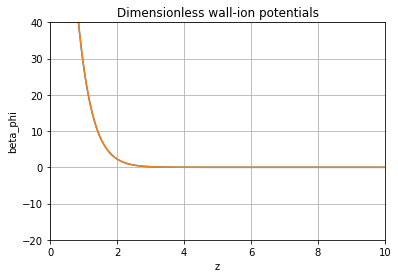

In [32]:
make_simple_plot(z, beta_phi_wi, "z", "beta_phi", "Dimensionless wall-ion potentials")

This dimensionless plot matches well with Figure 4.1(b) of thesis.

### Bulk fluid inputs

Not sure what to do here -- maybe run pyOZ for ionic fluid and try using c_{ij}(r) from this as an approximation?

In [33]:
# Assume all of the moments of the short-ranged bulk direct correlation functions to be zero initially

f1_ij = np.zeros(n_point, dtype=np.float64)
f2_ij = np.zeros(n_point, dtype=np.float64)

### Initial guess for solution $t_{wi}(z)$ - solving $F(t(z)) = 0$

In [34]:
t_wi = np.zeros((n_point, n_component), dtype=np.float64)    # initial guess of zero - maybe should be \beta \phi

# t_wi = beta_phi_wi

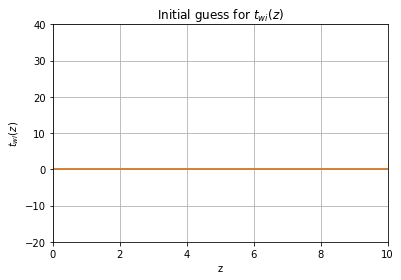

In [35]:
make_simple_plot(z, t_wi, "z", "$t_{wi}(z)$", "Initial guess for $t_{wi}(z)$")

In [36]:
def h_wi_z(t_wi, beta_phi_wi):
    for c in range(n_component):
        h_wi[:, c] = np.exp(t_wi[:, c]) * np.exp(-beta_phi_wi[:, c]) - 1.0
        return h_wi


In [38]:
# def f1_ij_z(direct_ij):
    

In [39]:
h_wi = h_wi_z(t_wi, beta_phi_wi)

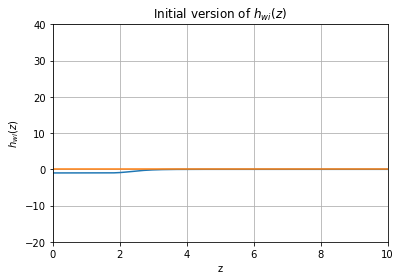

In [40]:
make_simple_plot(z, h_wi, "z", "$h_{wi}(z)$", "Initial version of $h_{wi}(z)$")

In [41]:
read_render_markdown_file("../docs/equation_5_9.md")
read_render_markdown_file("../docs/equation_5_9b.md")

$$ \large t_{wi}(z) = \ln \left[ g_{wi}(z) \exp(\beta \phi_{wi}(z)) \right] $$

$$ t_{wi}(z) ~=~ - \beta q_i \psi_0 + 2 \pi \sum_{j} \bar{\rho_j} \left \{  z f_{ij}^{(1)}(z) - f_{ij}^{(2)}(z) - \left( 2 \beta q_i q_j / \varepsilon \right ) \left(  \int_0^z dt t h_{wj}(t) + z \int_{z}^{\infty} dt h_{wj}(t) \right) + \int_0^{\infty} dt h_{wj}(t) f_{ij}^{(1)} ( | z - t | ) \right \} $$

In [42]:
beta_psi =  psi_0 * charge * beta

In [43]:
def t_wi_z(t_wi, beta_psi, beta_phi_wi, rho_i, f1_ij, f2_ij, z):
    h_wi = h_wi_z(t_wi, beta_phi_wi)

    for c in range(n_component):
        for k, _ in enumerate(z):
            int_0_z[k, c] = trapezoid(y=z[:k] * h_wi[:k, c], x=z[:k])
            int_z_inf[k, c] = trapezoid(y=h_wi[k:, c], x=z[k:])

            # int_0_inf[i] = 0  # trapezoid(y=h_wi*fabs(z, t), x=z)

            t_wi[k, c] = -beta_psi[c] + 2.0 * np.pi * (rho_i[c] * z[k] * f1_ij[k] - f2_ij[k]) + \
            2.0 * charge[c] * charge[c] / epsilon * (int_z_inf[k, c] + z[k] * int_0_z[k, c])  # + int_0_inf
    return t_wi


In [44]:
t_wi_z(t_wi, beta_psi, beta_phi_wi, rho_i, f1_ij, f2_ij, z)

array([[-1.16784748e-27,  0.00000000e+00],
       [-1.15631209e-27,  0.00000000e+00],
       [-1.14478391e-27,  0.00000000e+00],
       ...,
       [-7.64716408e-26,  0.00000000e+00],
       [-7.65099149e-26,  0.00000000e+00],
       [-7.65481890e-26,  0.00000000e+00]])

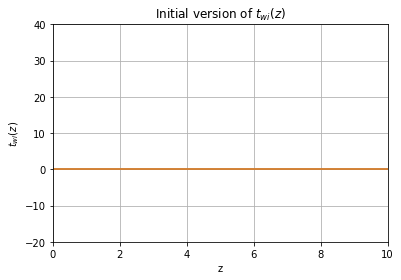

In [45]:
make_simple_plot(z, t_wi, "z", "$t_{wi}(z)$", "Initial version of $t_{wi}(z)$")

### Numerical solver: Newton-GMRES

In [54]:
# this should equal 0 (as t(z) converges to solution)

def func_opt(t_wi):
    return t_wi - t_wi_z(t_wi, beta_psi, beta_phi_wi, rho_i, f1_ij, f2_ij, z)

In [47]:
tolerance = 1e-9

In [60]:
solution = optim.root(func_opt, t_wi, method="krylov", jac=None, tol=tolerance, callback=None, options=None)

In [62]:
t_wi_solution = solution.x

In [63]:
t_wi_solution

array([[-1.16784748e-27,  0.00000000e+00],
       [-1.15631209e-27,  0.00000000e+00],
       [-1.14478391e-27,  0.00000000e+00],
       ...,
       [-7.64716408e-26,  0.00000000e+00],
       [-7.65099149e-26,  0.00000000e+00],
       [-7.65481890e-26,  0.00000000e+00]])